In [299]:

import matplotlib.pyplot as plt
plt.style.use('/home/joliveira/Documents/franck-hertz/joao.mplstyle')
# --- DEFINIÇÃO DO TEMA GLOBAL USANDO rcParams ---
plt.rcParams['figure.figsize'] = (20, 12) # Define o tamanho da figura para 10x6 polegadas
plt.rcParams['font.size'] = 14           # Define o tamanho da fonte geral como 14
plt.rcParams['axes.titlesize'] = 25      # Tamanho da fonte do título
plt.rcParams['axes.labelsize'] = 20      # Tamanho da fonte dos rótulos dos eixos
plt.rcParams['axes.grid'] = True        # Habilita/desabilita a grade em todos os gráficos
plt.rcParams['grid.linestyle'] = '-'      # Estilo da grade: tracejado
plt.rcParams['grid.alpha'] = 0.6         # Transparência da grade
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['savefig.dpi'] = 700        # Alta resolução para salvar as figuras
plt.rcParams['lines.linestyle'] = '-'    # Linha sólida
plt.rcParams['lines.linewidth'] = 3   # Espessura da linha
plt.rcParams['figure.facecolor'] = 'none'   # Fundo da figura transparente
plt.rcParams['axes.facecolor']   = 'none'   # Fundo dos eixos transparente
plt.rcParams['savefig.facecolor'] = 'none'  # Ao salvar, mantém transparente
plt.rcParams['savefig.transparent'] = True  # Salva figuras com fundo transparente
plt.rcParams['xtick.labelsize'] = 16    # Tamanho dos rótulos do eixo x
plt.rcParams['ytick.labelsize'] = 16    # Tamanho dos rótulos do eixo y
# ---------------------------------------------------



Missing colon in file '/home/joliveira/Documents/franck-hertz/joao.mplstyle', line 617 ('view raw')
Missing colon in file '/home/joliveira/Documents/franck-hertz/joao.mplstyle', line 618 ('matplotlibrc hosted with ❤ by GitHub')


In [300]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit

def plot_corrente_tensao(
    caminho_arquivo: str,
    normalizar: bool = False,
    salvar: bool = False,
    pasta_saida: str = None,
    mostrar_fitting: bool = False
):
    """
    Lê um arquivo .ods e plota Corrente vs Tensão com barras de erro.
    Opcionalmente, realiza um fitting da forma j = A * V^(3/2).

    Parâmetros:
    - caminho_arquivo: str → caminho do arquivo .ods
    - normalizar: bool → se True, aplica normalização (max-min) na Corrente
    - salvar: bool → se True, salva o gráfico em PNG
    - pasta_saida: str → caminho onde o arquivo será salvo (obrigatório se salvar=True)
    - mostrar_fitting: bool → se True, realiza e exibe o ajuste j = A * V^(3/2)
    """

    # Ler a planilha
    df = pd.read_excel(caminho_arquivo, engine="odf")

    # Garantir que as colunas necessárias existam
    colunas_necessarias = ["Tensao", "Corrente", "Incerteza corrente"]
    for col in colunas_necessarias:
        if col not in df.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no arquivo {caminho_arquivo}")

    # Guardar o valor máximo da corrente original
    corrente_max = df["Corrente"].max()

    # Normalização (opcional)
    if normalizar:
        df["Corrente"] = (df["Corrente"] - df["Corrente"].min()) / (df["Corrente"].max() - df["Corrente"].min())
        df["Incerteza corrente"] = df["Incerteza corrente"] / (corrente_max - df["Corrente"].min())

    # --- Plot dos dados experimentais ---
    plt.errorbar(
        df["Tensao"],
        df["Corrente"],
        yerr=df["Incerteza corrente"],
        fmt='-D',
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        label='Medição com incerteza'
    )

    # --- Fitting (opcional) ---
    if mostrar_fitting:
        def child_langmuir(V, A):
            return A * V**(3/2)

        try:
            popt, pcov = curve_fit(child_langmuir, df["Tensao"], df["Corrente"])
            A_fit = popt[0]
            A_err = np.sqrt(np.diag(pcov))[0]

            # Curva ajustada
            V_fit = np.linspace(df["Tensao"].min(), df["Tensao"].max(), 300)
            I_fit = child_langmuir(V_fit, A_fit)

            plt.plot(V_fit, I_fit, '--r', label=f"Fit: $I = {A_fit:.2e} \\cdot V^{{3/2}}$\n(A ± σ = {A_err:.1e})")
        except Exception as e:
            print(f"⚠️ Erro ao ajustar os dados: {e}")

    # --- Configurações do gráfico ---
    plt.xlabel("Tensão (V)")
    plt.ylabel("Corrente (A)" if not normalizar else "Corrente (normalizada)")
    plt.title("Corrente vs Tensão" + (" (normalizado)" if normalizar else ""))
    plt.legend()
    plt.grid(True)

    # --- Anotação se normalizado ---
    if normalizar:
        plt.annotate(
            f"Corrente máxima: {corrente_max:.2e} A",
            xy=(0.99, 0.01),
            xycoords="axes fraction",
            xytext=(-10, 10),
            textcoords="offset points",
            ha="right",
            va="bottom",
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.7)
        )

    plt.tight_layout()

    # --- Salvar ou mostrar ---
    if salvar:
        if pasta_saida is None:
            raise ValueError("Você deve fornecer o parâmetro 'pasta_saida' quando salvar=True.")

        os.makedirs(pasta_saida, exist_ok=True)
        nome_arquivo = os.path.splitext(os.path.basename(caminho_arquivo))[0]
        if normalizar:
            nome_arquivo += "_normalizado"
        nome_arquivo += ".png"

        caminho_saida = os.path.join(pasta_saida, nome_arquivo)
        plt.savefig(caminho_saida, dpi=300, bbox_inches="tight")
        print(f"✅ Gráfico salvo em: {caminho_saida}")
        plt.show()
        plt.close()
    else:
        plt.show()


In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

def plot_corrente_tensao_pasta(
    pasta_dados: str,
    normalizar: bool = False,
    salvar: bool = False,
    pasta_saida: str = None
):
    """
    Lê todos os arquivos .ods na pasta com nome no formato 'm_1-T_#C.ods'
    e plota Corrente vs Tensão para cada temperatura.

    Parâmetros:
    - pasta_dados: str → caminho da pasta contendo os arquivos .ods
    - normalizar: bool → se True, normaliza as correntes de todos os arquivos
                         pelo valor máximo global (corrente máxima entre todos)
    - salvar: bool → se True, salva o gráfico em PNG
    - pasta_saida: str → caminho onde o arquivo será salvo (obrigatório se salvar=True)
    """

    padrao_arquivo = re.compile(r"m_1-T_(\d+)C\.ods$")
    arquivos = [f for f in os.listdir(pasta_dados) if padrao_arquivo.match(f)]

    if not arquivos:
        raise FileNotFoundError("Nenhum arquivo encontrado com o padrão 'm_1-T_#C.ods'.")

    if salvar and pasta_saida is None:
        raise ValueError("Você deve fornecer o parâmetro 'pasta_saida' ao escolher salvar=True.")

    # Cria pasta de saída se necessário
    if salvar:
        os.makedirs(pasta_saida, exist_ok=True)

    dados_arquivos = []
    max_global = -float("inf")

    # --- Leitura e coleta do máximo global ---
    for arquivo in arquivos:
        caminho_arquivo = os.path.join(pasta_dados, arquivo)
        df = pd.read_excel(caminho_arquivo, engine="odf")

        # Checar colunas obrigatórias
        for col in ["Tensao", "Corrente", "Incerteza corrente"]:
            if col not in df.columns:
                raise ValueError(f"Coluna '{col}' não encontrada no arquivo {arquivo}")

        temperatura = int(padrao_arquivo.match(arquivo).group(1))
        corrente_max = df["Corrente"].max()
        max_global = max(max_global, corrente_max)

        dados_arquivos.append((temperatura, df, corrente_max))

    # --- Plotagem ---
    plt.figure()

    for temperatura, df, corrente_max in sorted(dados_arquivos):
        if normalizar:
            df["Corrente"] = df["Corrente"] / max_global
            df["Incerteza corrente"] = df["Incerteza corrente"] / max_global

        plt.errorbar(
            df["Tensao"],
            df["Corrente"],
            yerr=df["Incerteza corrente"],
            fmt='-D',
            capsize=3,
            label=f"{temperatura}°C"
        )

    plt.xlabel("Tensão (V)")
    plt.ylabel("Corrente (A)" if not normalizar else "Corrente (normalizada)")
    plt.title("Corrente vs Tensão para diferentes temperaturas" + (" (normalizado)" if normalizar else ""))
    plt.legend(title="Temperatura",
               fontsize=20)
    plt.grid(True)

    # --- Anotação de corrente máxima global ---
    if normalizar:
        plt.annotate(
            f"Corrente máxima global: {max_global:.2e} A",
            xy=(0.99, 0.01),
            xycoords="axes fraction",
            xytext=(-10, 10),
            textcoords="offset points",
            ha="right",
            va="bottom",
            fontsize=20,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.7)
        )

    plt.tight_layout()

    # --- Salvar ou mostrar ---
    if salvar:
        nome_arquivo = "corrente_vs_tensao"
        if normalizar:
            nome_arquivo += "_normalizado"
        nome_arquivo += ".png"

        caminho_saida = os.path.join(pasta_saida, nome_arquivo)
        plt.savefig(caminho_saida, dpi=300, bbox_inches="tight")
        print(f"✅ Gráfico salvo em: {caminho_saida}")
        plt.show()
        plt.close()
    else:
        plt.show()


✅ Gráfico salvo em: Graficos Gerados/m_1-T_1775C_normalizado.png


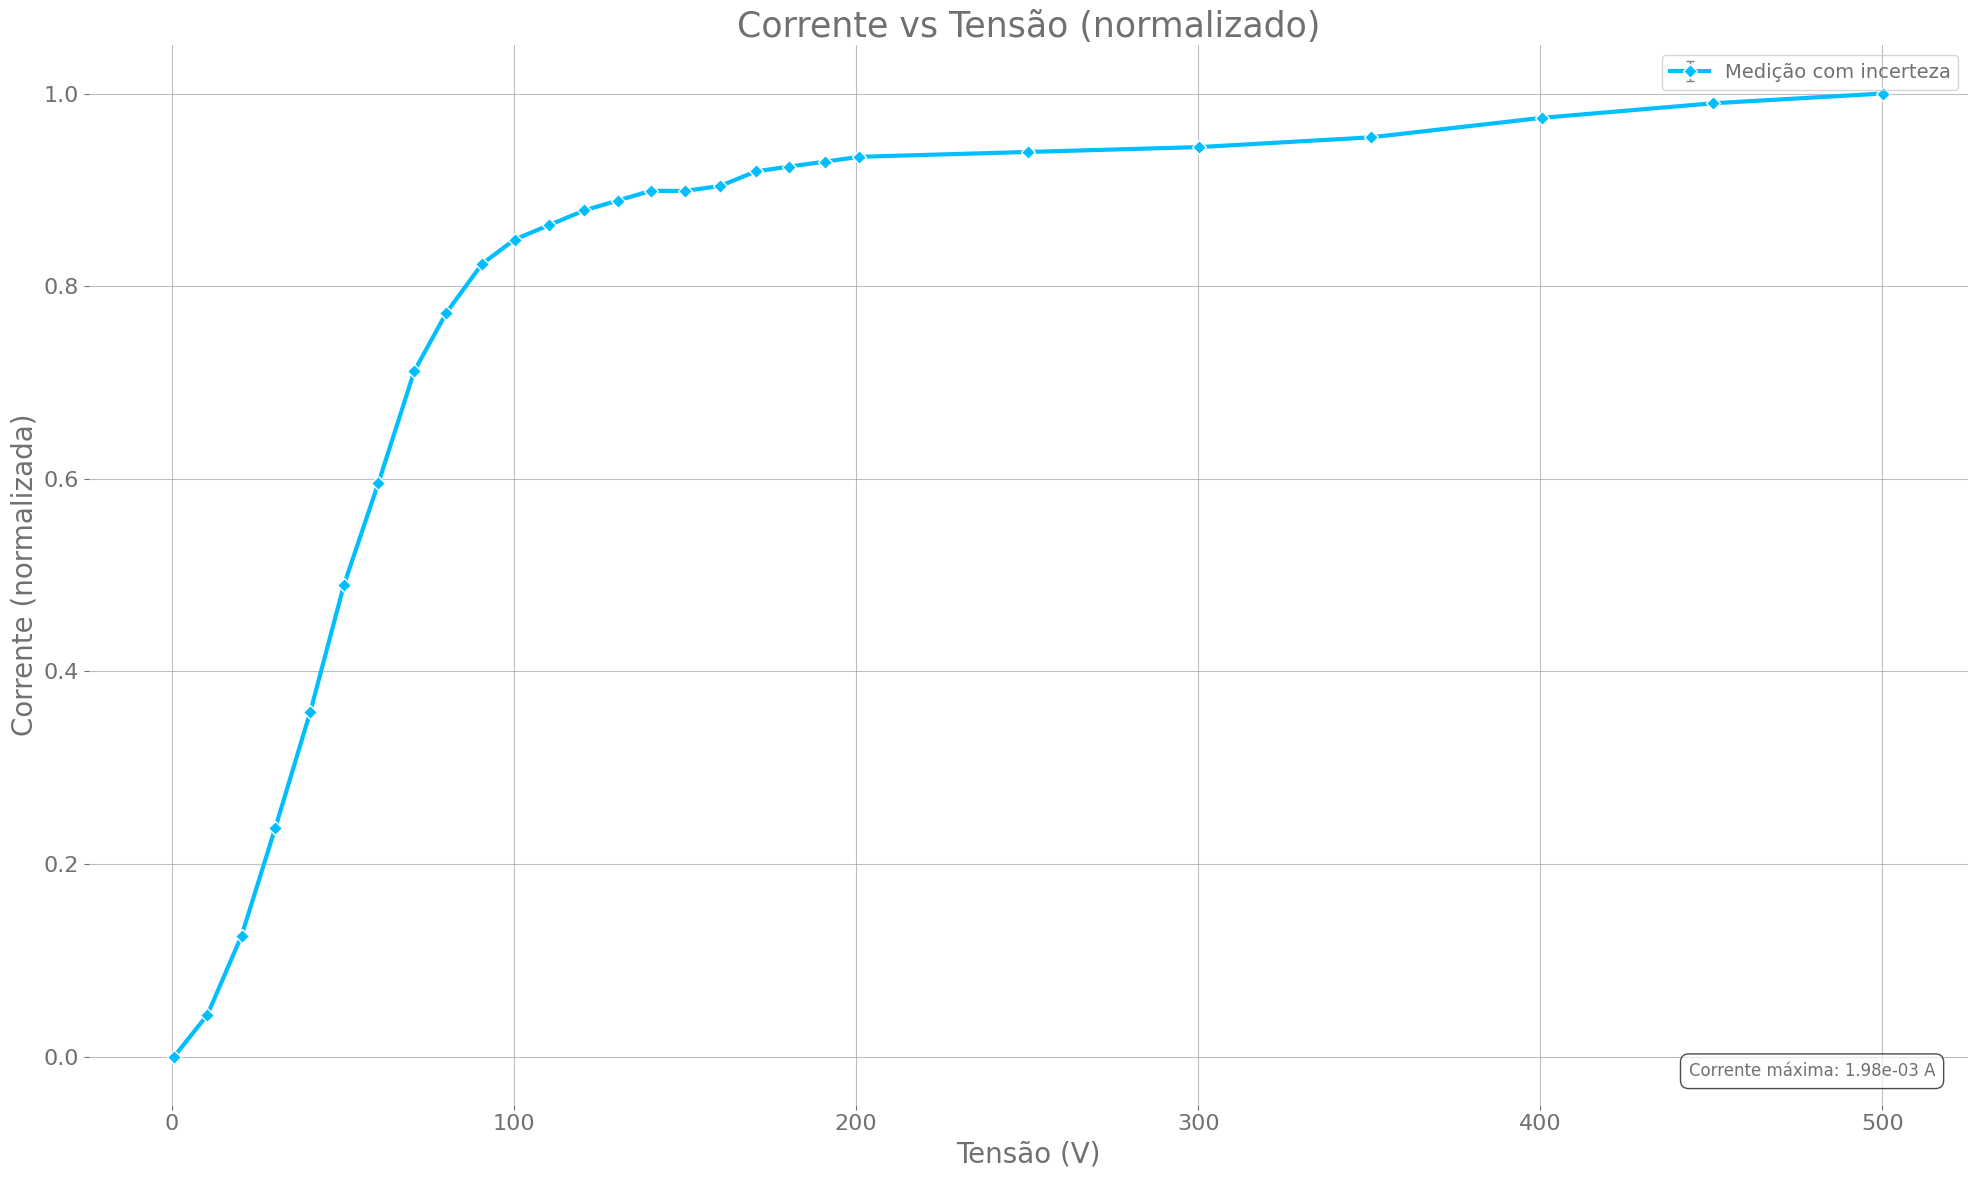

✅ Gráfico salvo em: Graficos Gerados/corrente_vs_tensao_normalizado.png


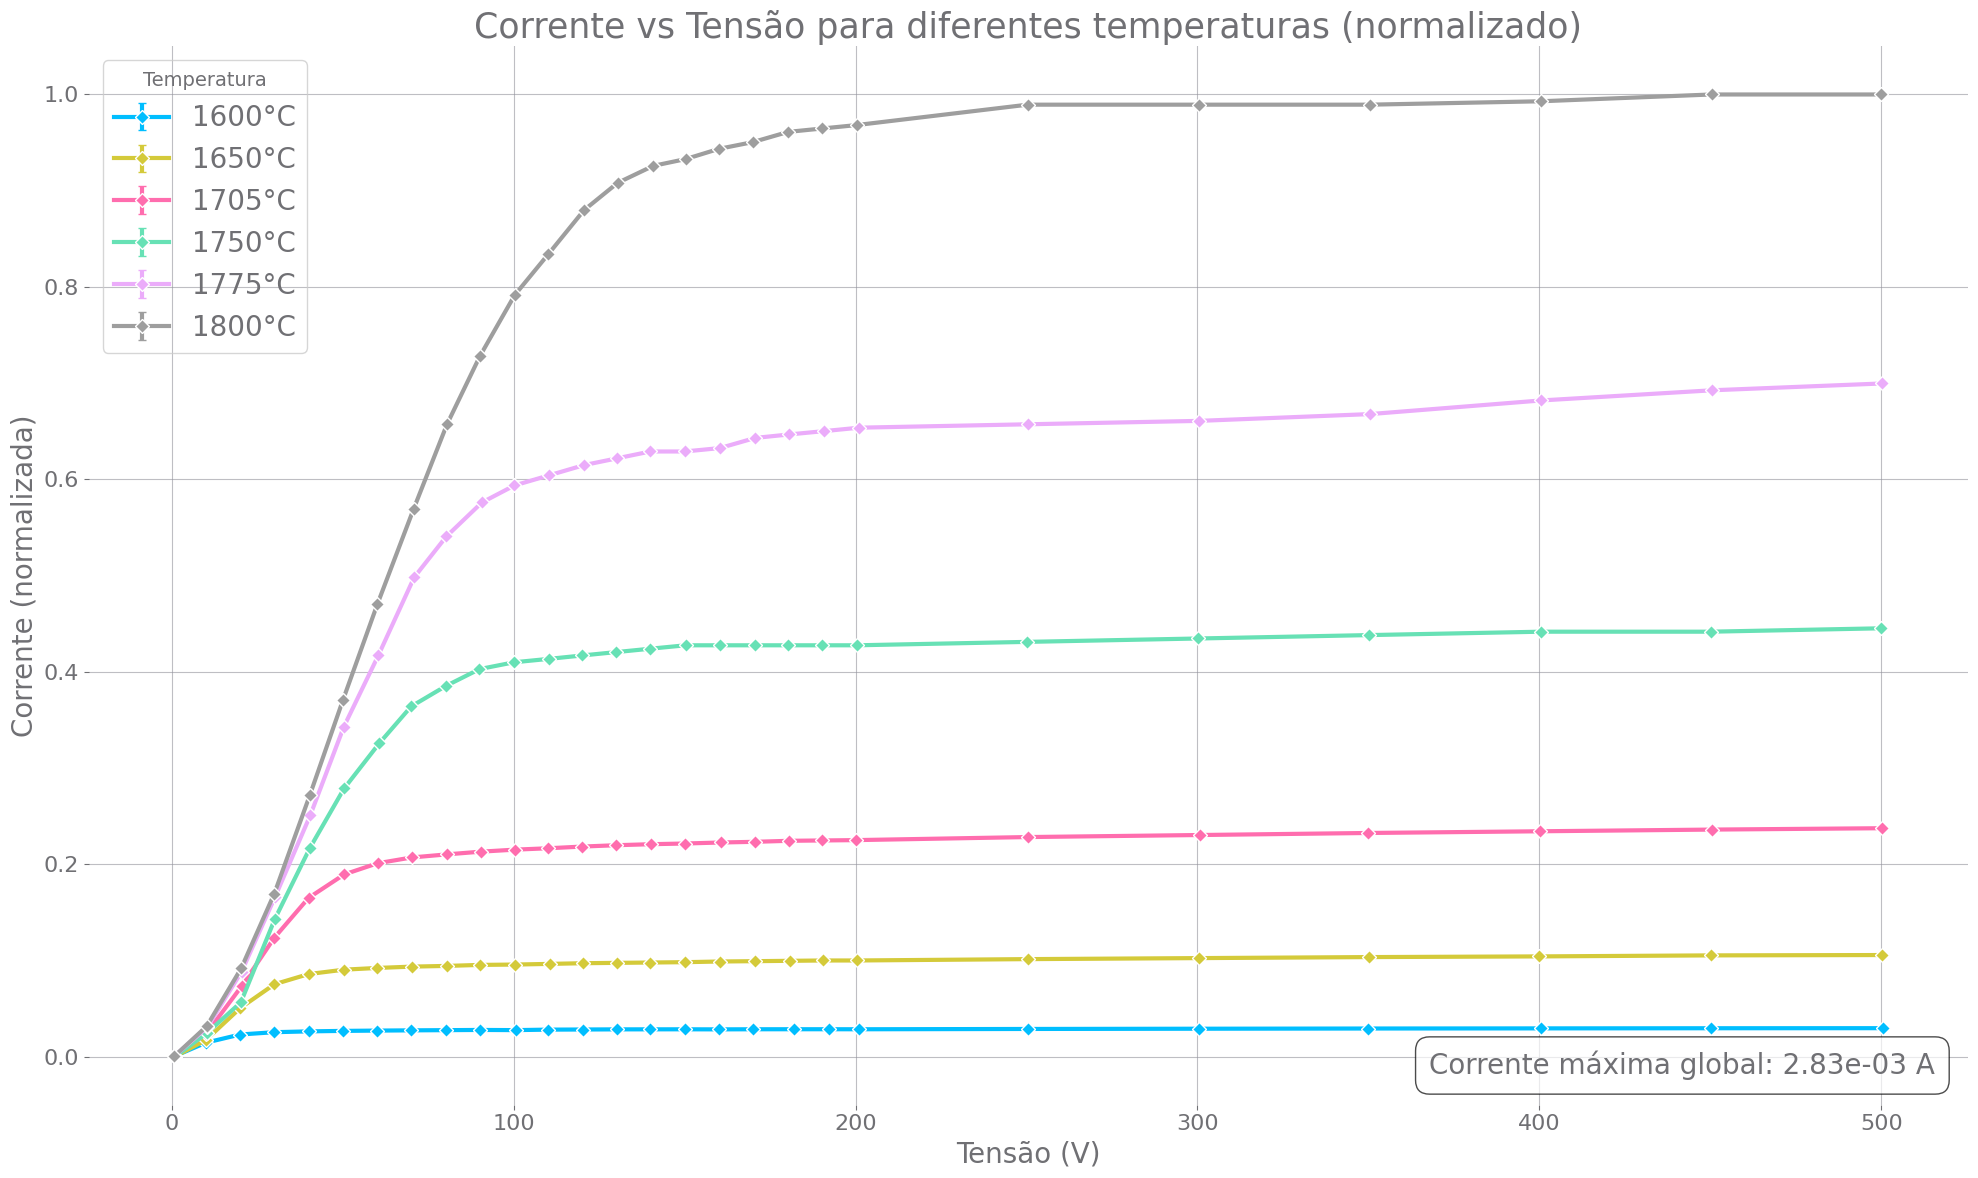

In [302]:
plot_corrente_tensao(
    caminho_arquivo="Dados Obtidos 06.11.2025/m_1-T_1775C.ods",
    normalizar=True,
    salvar=True,
    mostrar_fitting=False,  # mostra o ajuste da Lei de Child-Langmuir
    pasta_saida="Graficos Gerados/"
)
# Normalizar e salvar
plot_corrente_tensao_pasta(
    pasta_dados="Dados Obtidos 06.11.2025/",
    normalizar=True,
    salvar=True,
    pasta_saida="Graficos Gerados/"
)


In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def ajustar_child_langmuir_linearizado(caminho_arquivo: str, V_sat_estimado: float = None, limite_saturacao: float = 0.05):
    """
    Ajusta dados experimentais à lei de Child–Langmuir (I = k * V^(3/2))
    usando o método linearizado: I^(2/3) = a * V + b.

    Parâmetros
    ----------
    caminho_arquivo : str
        Caminho do arquivo .ods contendo colunas: Tensao | Incerteza_Tensao | Corrente | Incerteza_Corrente
    V_sat_estimado : float, opcional
        Estimativa (em volts) do início da saturação. Se None, o programa detecta automaticamente.
    limite_saturacao : float
        Limiar usado na detecção automática (fração da derivada normalizada).
    """
    # --- Leitura dos dados ---
    df = pd.read_excel(caminho_arquivo, engine="odf")
    df.columns = ["Tensao", "Incerteza_Tensao", "Corrente", "Incerteza_Corrente"]
    df = df[df["Tensao"] > 0]

    V = df["Tensao"].values
    I = df["Corrente"].values

    # --- Determinação do ponto de corte ---
    if V_sat_estimado is not None:
        V_sat = V_sat_estimado
        idx_sat = np.argmin(np.abs(V - V_sat))
        print(f"[INFO] Usando V_sat estimado = {V_sat:.2f} V (índice {idx_sat}).")
    else:
        dIdV = np.gradient(I, V)
        dIdV_norm = dIdV / np.max(dIdV)
        indices_saturacao = np.where(dIdV_norm < limite_saturacao)[0]
        if len(indices_saturacao) > 0:
            idx_sat = indices_saturacao[0]
            V_sat = V[idx_sat]
            print(f"[INFO] Regime de saturação detectado automaticamente a partir de ~{V_sat:.2f} V.")
        else:
            print("[INFO] Nenhum regime de saturação detectado — ajustando todos os pontos.")
            idx_sat = len(V)
            V_sat = None

    # --- Seleciona dados até o ponto de saturação ---
    V_fit_data = V[:idx_sat]
    I_fit_data = I[:idx_sat]

    # --- Linearização: I^(2/3) = a * V + b ---
    I23 = I_fit_data ** (2/3)

    # Ajuste linear
    slope, intercept, r_value, p_value, std_err = linregress(V_fit_data, I23)

    # Recupera k (a partir de slope = k^(2/3))
    k_fit = slope ** (3/2)
    k_err = (1.5 * slope**0.5 * std_err) if slope > 0 else np.nan
    r2 = r_value**2

    # --- Curvas para plot ---
    V_lin = np.linspace(V_fit_data.min(), V_fit_data.max(), 300)
    I23_fit = slope * V_lin + intercept
    I_fit = (I23_fit) ** (3/2)

    # --- Plot 1: Dados linearizados ---
    plt.plot(V_fit_data, I23, 'o', label="Dados linearizados")
    plt.plot(V_lin, I23_fit, 'r-', label=f"Ajuste linear\n$a={slope:.3e}$, $R^2={r2:.4f}$")
    plt.xlabel("Tensão (V)")
    plt.ylabel("$I^{2/3}$ (A$^{2/3}$)")
    plt.title("Linearização da Lei de Child–Langmuir")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Dados originais com curva ajustada ---
    plt.errorbar(
        V, I,
        xerr=df["Incerteza_Tensao"], yerr=df["Incerteza_Corrente"],
        fmt='o', markersize=5, capsize=3,
        label="Dados experimentais", alpha=0.7
    )
    plt.plot(V_lin, I_fit, 'r-', lw=2,
             label=f"Ajuste Child–Langmuir\n$k={k_fit:.2e}$, $R^2={r2:.4f}$")

    if V_sat is not None:
        plt.axvline(V_sat, color='gray', ls='--', label=f"Início da saturação ~{V_sat:.1f} V")
        plt.xlim(V.min(), V_sat * 1.1)
    else:
        plt.xlim(V.min(), V.max())

    plt.xlabel("Tensão (V)")
    plt.ylabel("Corrente (A)")
    plt.title("Ajuste pela Lei de Child–Langmuir (linearizado)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return k_fit, k_err, r2, V_sat


[INFO] Usando V_sat estimado = 80.00 V (índice 8).


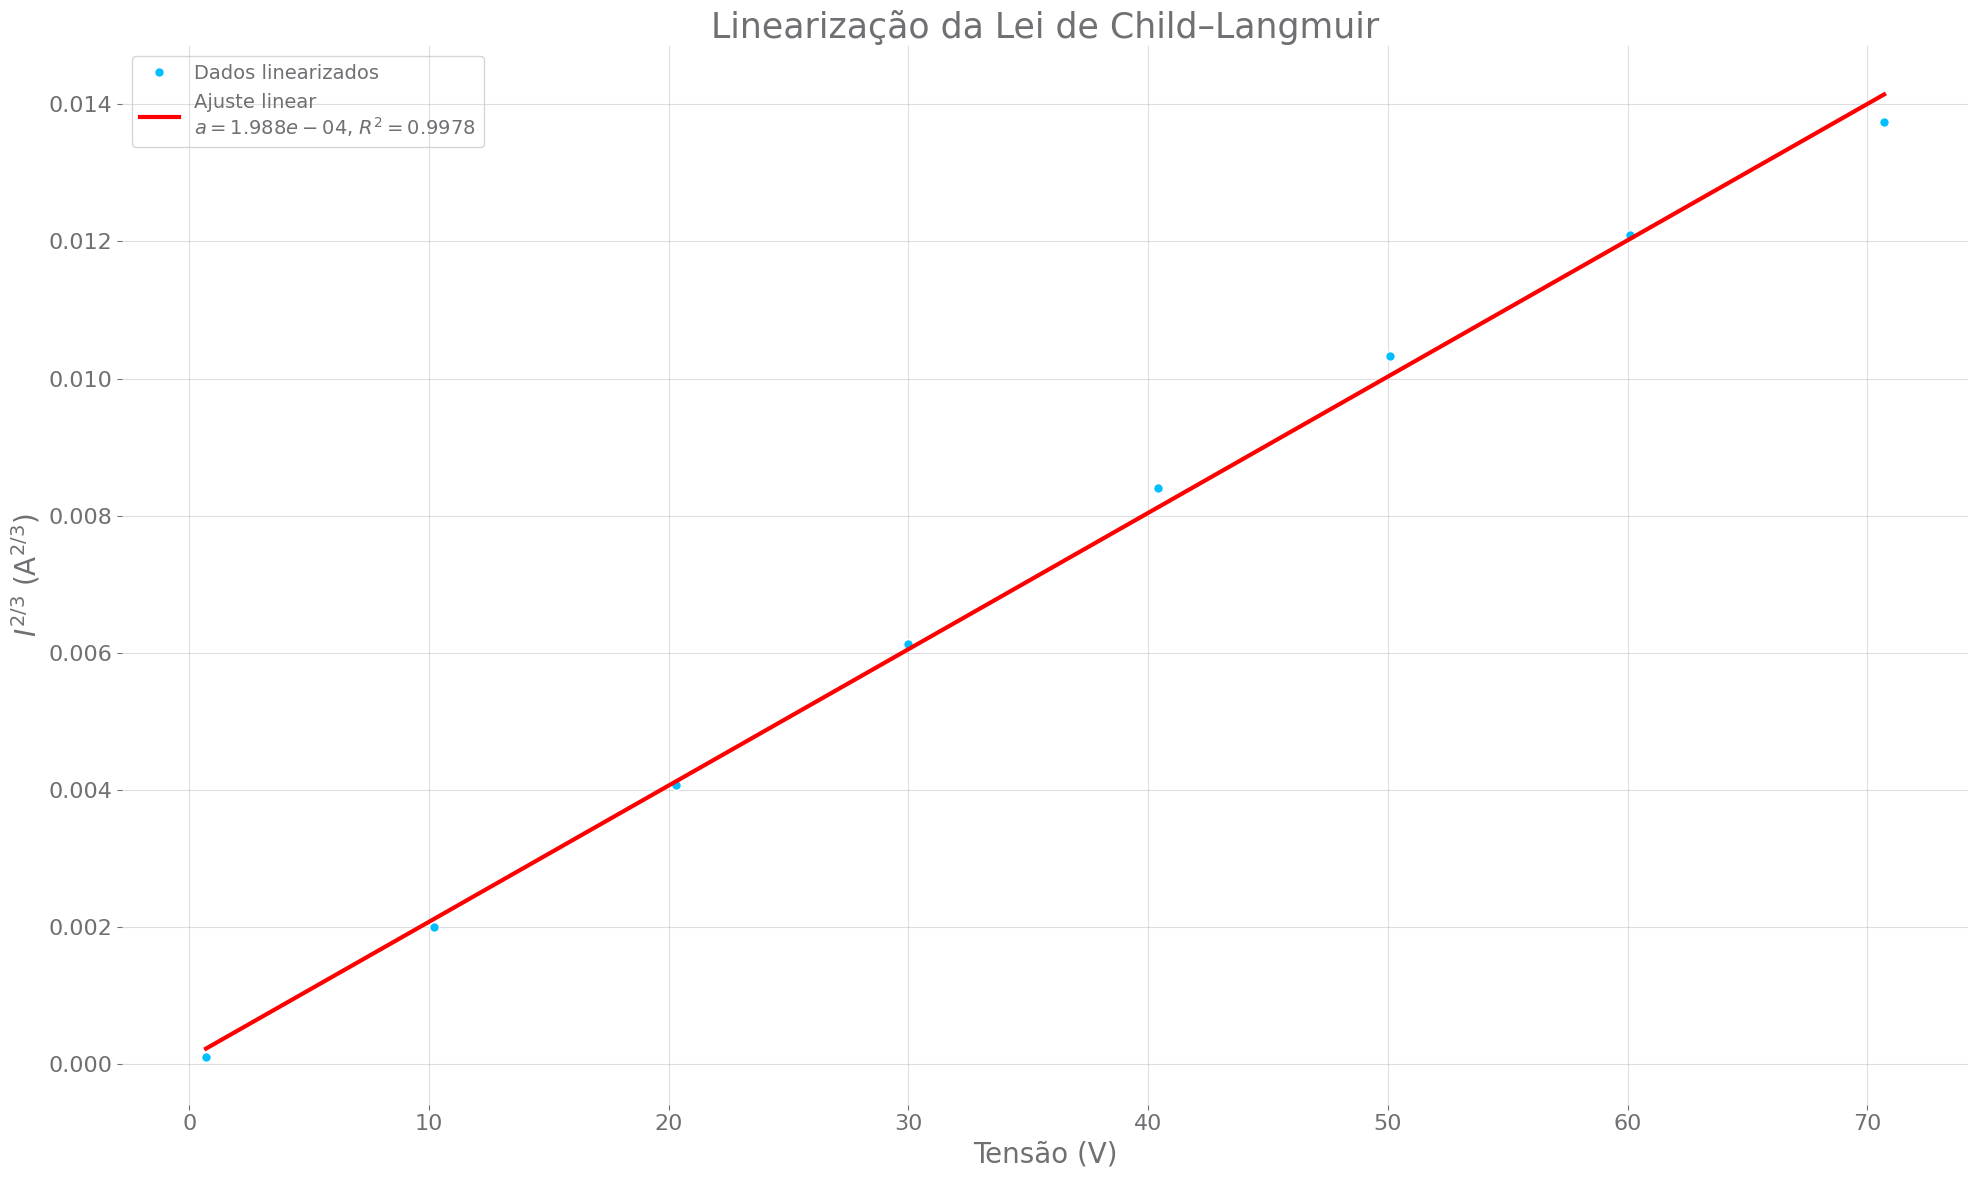

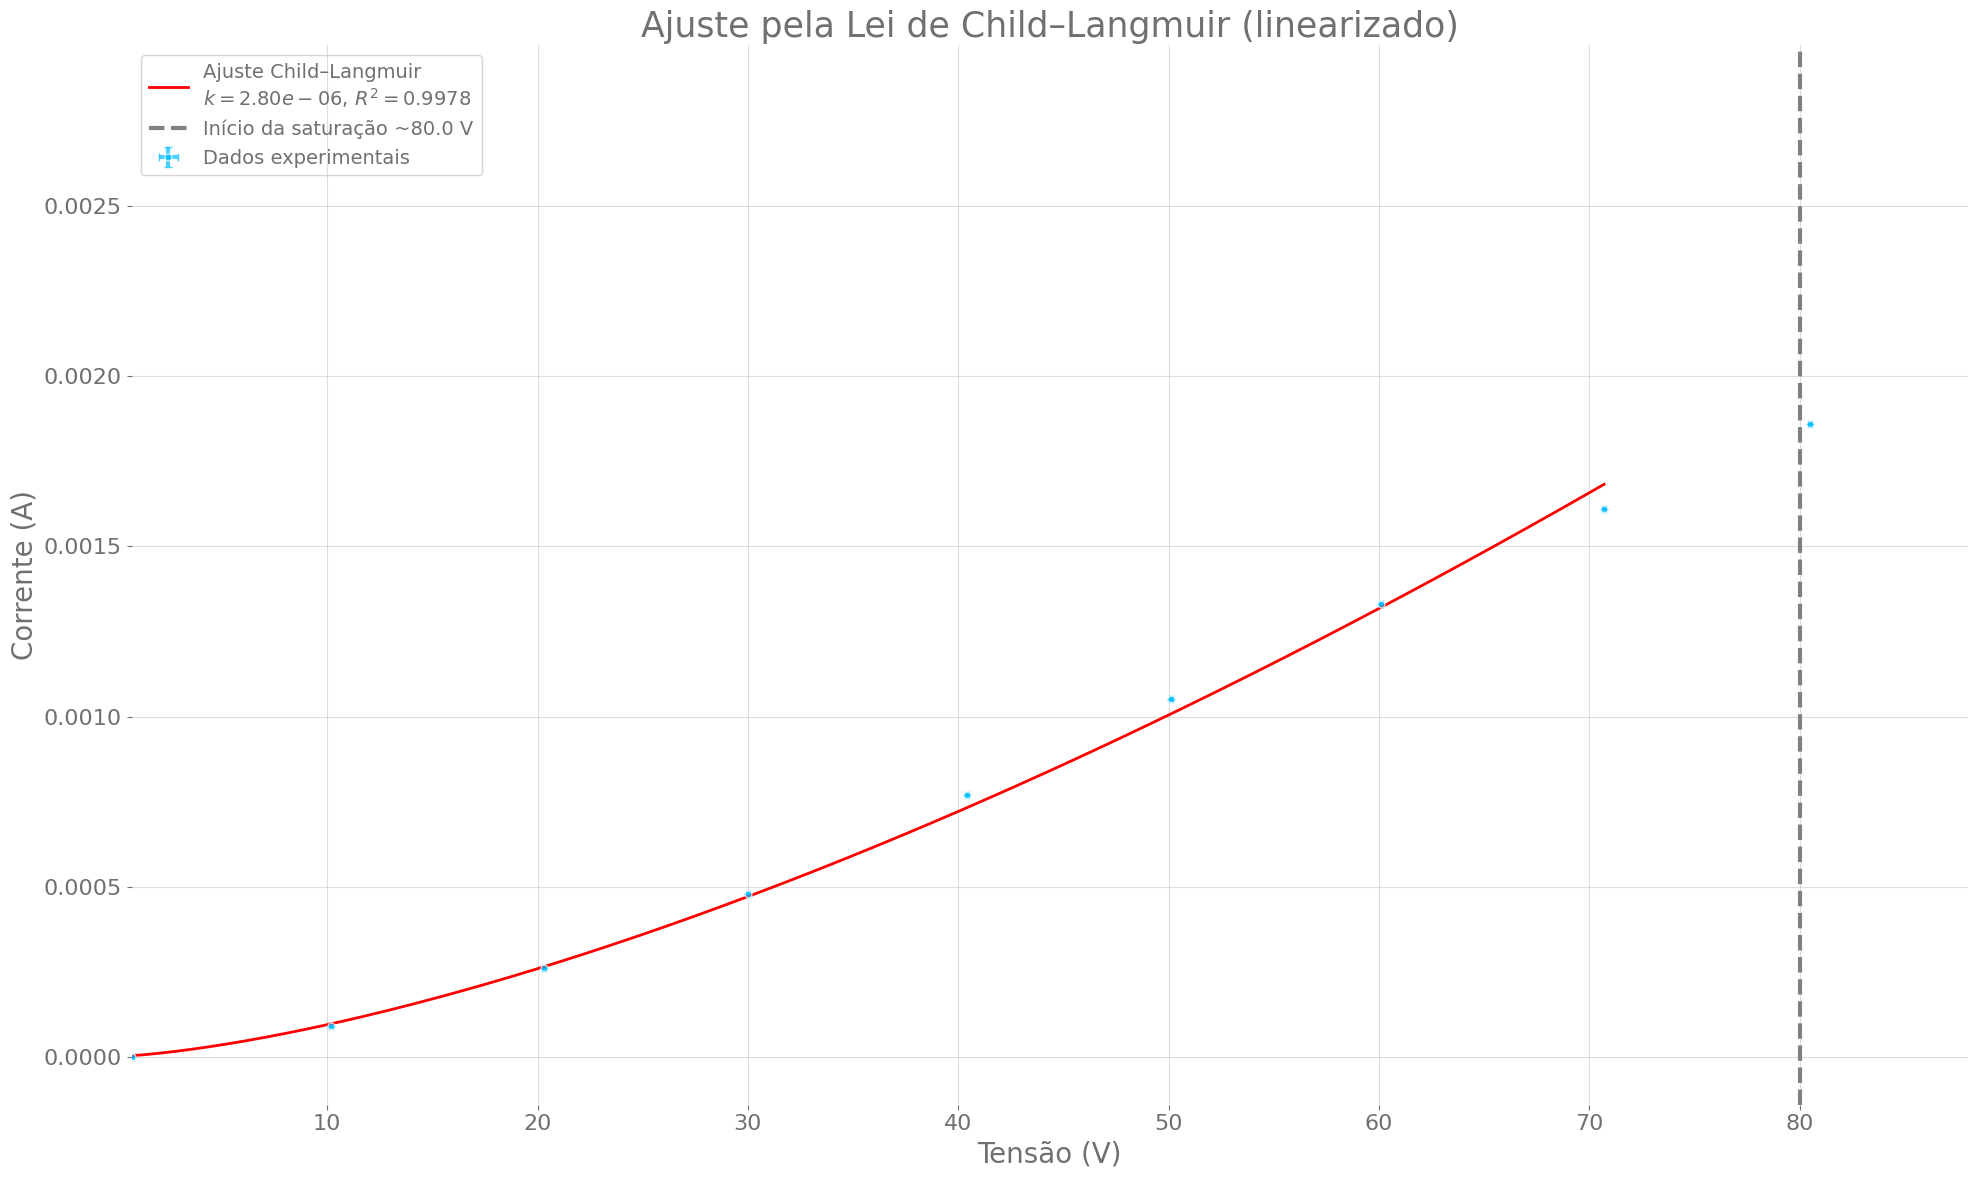

In [304]:
k, k_err, r2, V_sat = ajustar_child_langmuir_linearizado("Dados Obtidos 06.11.2025/m_1-T_1800C.ods", V_sat_estimado=80)


--- Aviso: A estimativa inicial linear estava fora dos bounds ---
  Original (p0): A=6.75e+03, phi=5.346
  Ajustada (p0): A=1.00e+03, phi=5.346
----------------------------------------------------------------


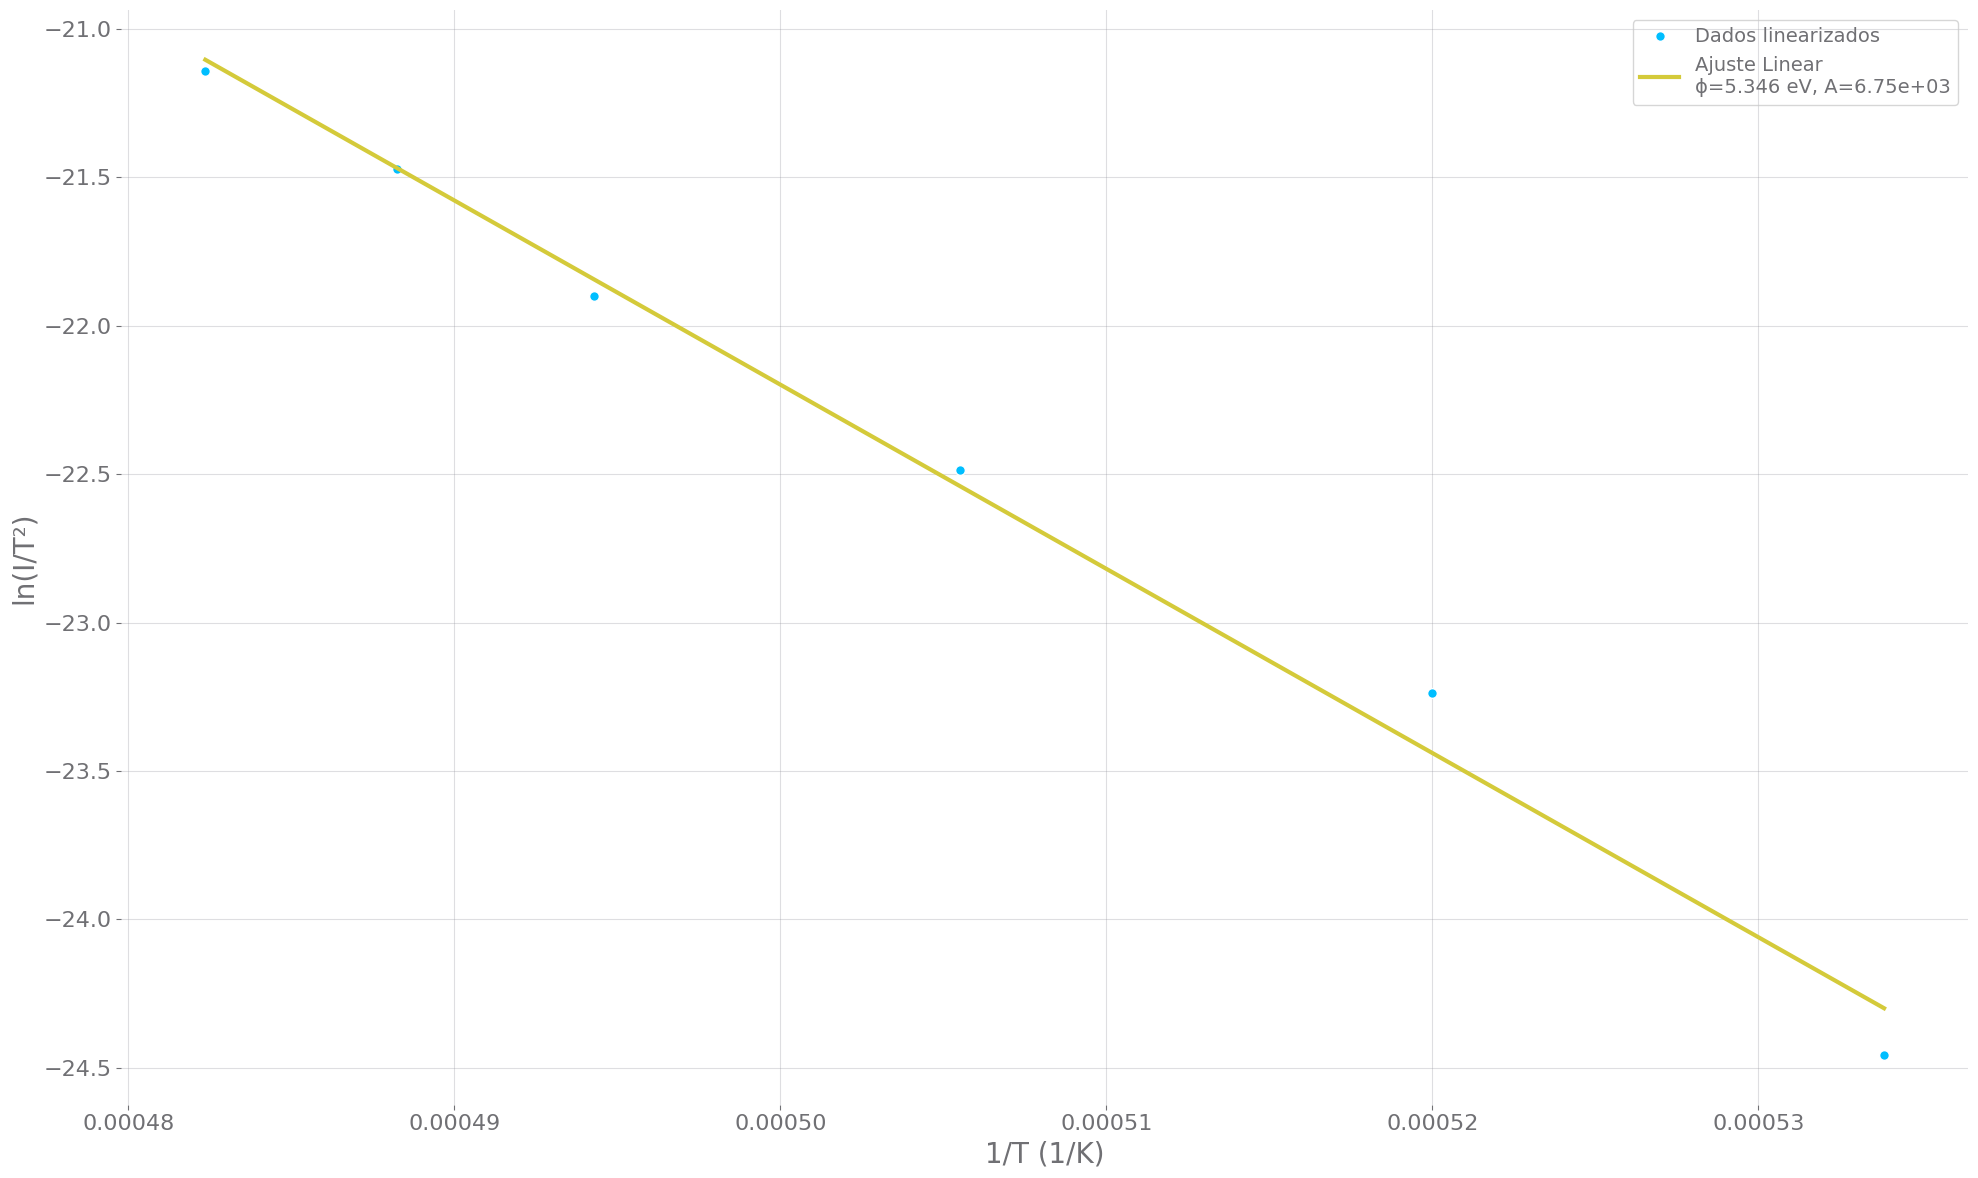

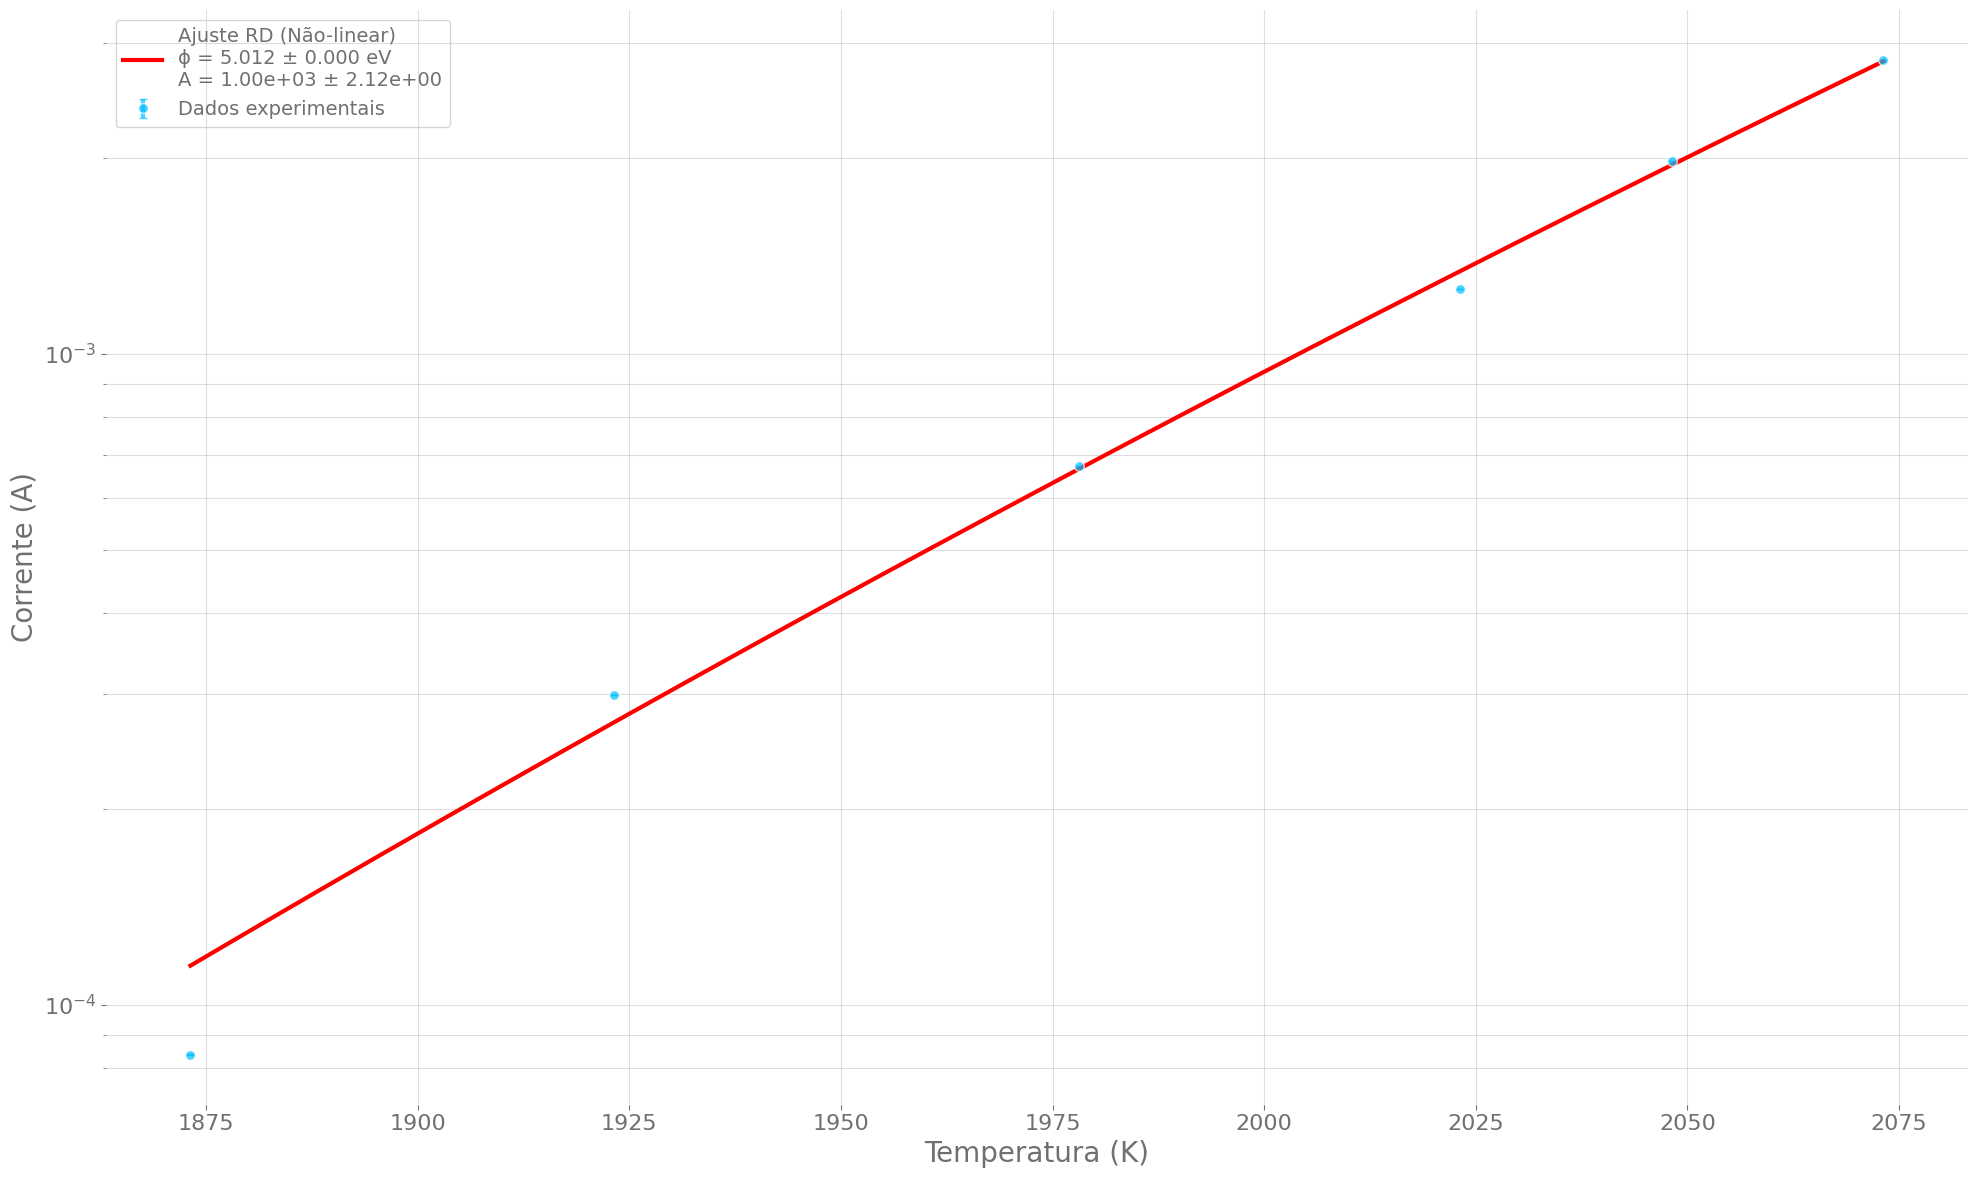

{'A_fit': np.float64(999.9999999988074), 'A_err': np.float64(2.115231461942493), 'phi_fit': np.float64(5.011916854186883), 'phi_err': np.float64(0.00037467622066504445), 'A_lin': np.float64(6749.795307608035), 'phi_lin': np.float64(5.345518375450704)}


In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ajustar_richardson_dushman(caminho_arquivo: str):
    kB = 8.617333262145e-5  # eV/K

    df = pd.read_excel(caminho_arquivo, engine="odf")
    df.columns = ["temp_C", "Corrente", "Incerteza_Corrente"]

    # Conversão para Kelvin
    T = df["temp_C"].values + 273.15
    I = df["Corrente"].values
    sigma_I = df["Incerteza_Corrente"].values

    # Remove valores não positivos
    mask = I > 0
    T, I, sigma_I = T[mask], I[mask], sigma_I[mask]

    # Linearização: ln(I/T²) = ln(A) - φ/(kB*T)
    x = 1 / T
    y = np.log(I / T**2)

    # Ajuste linear para estimar A e φ
    coef = np.polyfit(x, y, 1)
    slope, intercept = coef
    phi_est = -slope * kB
    A_est = np.exp(intercept)

    # --- Início das Correções ---

    # 1. Definir os limites (bounds) de forma clara
    lower_bounds = [1e-20, 0]  # Limite inferior [A_min, phi_min]
    upper_bounds = [1e3, 10]   # Limite superior [A_max, phi_max]
    bounds = (lower_bounds, upper_bounds)

    # 2. Garantir que a estimativa inicial (p0) esteja DENTRO dos limites
    #    Isso corrige o erro 'Initial guess is outside of provided bounds'
    p0_initial = [A_est, phi_est]
    p0_clipped = [
        np.clip(p0_initial[0], lower_bounds[0], upper_bounds[0]), # Clipa A_est
        np.clip(p0_initial[1], lower_bounds[1], upper_bounds[1])  # Clipa phi_est
    ]

    # Opcional: Imprime um aviso se o chute inicial foi alterado
    if not np.allclose(p0_initial, p0_clipped):
        print("--- Aviso: A estimativa inicial linear estava fora dos bounds ---")
        print(f"  Original (p0): A={p0_initial[0]:.2e}, phi={p0_initial[1]:.3f}")
        print(f"  Ajustada (p0): A={p0_clipped[0]:.2e}, phi={p0_clipped[1]:.3f}")
        print("----------------------------------------------------------------")


    # Função Richardson-Dushman
    def richardson_I(T, A, phi):
        return A * T**2 * np.exp(-phi / (kB * T))

    # 3. Ajuste não-linear com p0 corrigido e usando sigmas
    try:
        popt, pcov = curve_fit(
            richardson_I, T, I,
            p0=p0_clipped,         # <--- CORREÇÃO 1: Usar o p0 "clipado"
            bounds=bounds,
            sigma=sigma_I,         # <--- CORREÇÃO 2: Usar as incertezas
            absolute_sigma=True    # <--- CORREÇÃO 2: Tratar sigmas como absolutos
        )
        A_fit, phi_fit = popt
        A_err, phi_err = np.sqrt(np.diag(pcov))
    
    except RuntimeError as e:
        print(f"Erro no ajuste 'curve_fit': {e}")
        print("O ajuste não-linear falhou. Retornando valores do ajuste linear.")
        # Retorna N/A ou os valores lineares se o ajuste falhar
        A_fit, phi_fit = np.nan, np.nan
        A_err, phi_err = np.nan, np.nan

    # --- Fim das Correções ---


    # --- PLOTS ---
    # 1. Linearizado
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = slope * x_fit + intercept

    plt.figure() # Adiciona plt.figure() para evitar sobreposição de plots
    plt.plot(x, y, 'o', label='Dados linearizados')
    plt.plot(x_fit, y_fit, '-', label=f'Ajuste Linear\nϕ={phi_est:.3f} eV, A={A_est:.2e}')
    plt.xlabel('1/T (1/K)')
    plt.ylabel('ln(I/T²)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Corrente real (escala log)
    T_fit = np.linspace(T.min(), T.max(), 300)
    
    plt.figure() # Adiciona plt.figure()
    plt.errorbar(T, I, yerr=sigma_I, fmt='o', capsize=3, label='Dados experimentais', alpha=0.7)
    
    # Só plota o ajuste não-linear se ele tiver sido bem-sucedido
    if not np.isnan(A_fit):
        I_fit = richardson_I(T_fit, A_fit, phi_fit)
        label_fit = (f'Ajuste RD (Não-linear)\n'
                     f'ϕ = {phi_fit:.3f} ± {phi_err:.3f} eV\n'
                     f'A = {A_fit:.2e} ± {A_err:.2e}')
        plt.plot(T_fit, I_fit, '-', label=label_fit, color='red')

    plt.yscale('log')
    plt.xlabel('Temperatura (K)')
    plt.ylabel('Corrente (A)')
    plt.legend()
    plt.grid(alpha=0.3, which='both')
    plt.tight_layout()
    plt.show()

    return {
        "A_fit": A_fit,
        "A_err": A_err,
        "phi_fit": phi_fit,
        "phi_err": phi_err,
        "A_lin": A_est,
        "phi_lin": phi_est
    }

# === Exemplo de uso ===
# Certifique-se que o caminho do arquivo está correto!
result = ajustar_richardson_dushman("Dados Obtidos 06.11.2025/m_2-T_all.ods")
print(result)